<a href="https://colab.research.google.com/github/ullasbc02/obesity-risk-analytics/blob/main/05_temporal_trend_early_warning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
import os
import pandas as pd
from sklearn.linear_model import LinearRegression
import json
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

In [3]:
DATA = "/content/drive/MyDrive/obesity-risk-analytics/dashboard_data_final/"
# GEOJSON
with open(DATA + "counties_fips.geojson", "r") as f:
    counties_geojson = json.load(f)

In [4]:
PATH = '/content/drive/MyDrive/obesity-analytics-notebooks/Multi-Year-Trend/Dataset'
df_time = pd.read_csv(
    os.path.join(PATH, 'final_clean_county_panel_geometry_2010_2023.csv'),
    dtype={"geoId": str}
)

In [5]:
df_time["fips"] = df_time["fips"].astype(str).str.zfill(5)
df_time

,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,geoid,year,county_name,state_abbr,metro_nonmetro,obesity_rate,poverty_rate,physical_inactivity,median_household_income,unemployment_rate,fips
0,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2010,Autauga County,AL,Metropolitan,0.287002,0.119001,0.248003,53049.0,0.088081,01001
1,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2011,Autauga County,AL,Metropolitan,0.260001,0.149001,0.261000,48863.0,0.083459,01001
2,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2012,Autauga County,AL,Metropolitan,0.295002,0.127000,0.242004,51441.0,0.071035,01001
3,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2013,Autauga County,AL,Metropolitan,0.284003,0.134999,0.259002,51868.0,0.063142,01001
4,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2014,Autauga County,AL,Metropolitan,0.311003,0.131001,0.248001,54366.0,0.058076,01001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43829,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2019,Chesterfield County,VA,Metropolitan,0.350001,0.066000,0.231000,81641.0,0.027124,51041
43830,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2020,Chesterfield County,VA,Metropolitan,0.356000,0.066000,0.219000,83598.0,0.060530,51041
43831,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2021,Chesterfield County,VA,Metropolitan,0.349000,0.074000,0.191000,86101.0,0.036161,51041
43832,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2022,Chesterfield County,VA,Metropolitan,0.363001,0.069000,0.196000,100149.0,0.027051,51041


In [6]:
# Convert geojson to GeoDataFrame
gdf_counties = gpd.GeoDataFrame.from_features(counties_geojson["features"])

# Inspect available columns (run once visually)
print("GeoJSON Columns:", gdf_counties.columns)

# Your GEOID comes from GEO_ID inside properties
gdf_counties["GEOID"] = (
    gdf_counties["GEO_ID"]
    .astype(str)
    .str.replace("0500000US", "", regex=False)
    .str.zfill(5)
)

# Ensure df_dash GEOID is formatted correctly
df_time["fips"] = df_time["fips"].astype(str).str.zfill(5)

#  Merge geometry + obesity data
gdf = gdf_counties.merge(df_time, left_on="GEOID", right_on="fips", how="inner")

print("Final Spatial Rows:", len(gdf))  # MUST be > 3000
gdf.head()

GeoJSON Columns: Index(['geometry', 'GEO_ID', 'STATE', 'COUNTY', 'NAME', 'LSAD', 'CENSUSAREA'], dtype='object')
Final Spatial Rows: 43834


,geometry_x,GEO_ID_x,STATE_x,COUNTY_x,NAME_x,LSAD_x,CENSUSAREA_x,GEOID_x,geometry_y,GEO_ID_y,...,year,county_name,state_abbr,metro_nonmetro,obesity_rate,poverty_rate,physical_inactivity,median_household_income,unemployment_rate,fips
0,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",0500000US01001,01,001,Autauga,County,594.436,01001,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,...,2010,Autauga County,AL,Metropolitan,0.287002,0.119001,0.248003,53049.0,0.088081,01001
1,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",0500000US01001,01,001,Autauga,County,594.436,01001,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,...,2011,Autauga County,AL,Metropolitan,0.260001,0.149001,0.261000,48863.0,0.083459,01001
2,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",0500000US01001,01,001,Autauga,County,594.436,01001,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,...,2012,Autauga County,AL,Metropolitan,0.295002,0.127000,0.242004,51441.0,0.071035,01001
3,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",0500000US01001,01,001,Autauga,County,594.436,01001,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,...,2013,Autauga County,AL,Metropolitan,0.284003,0.134999,0.259002,51868.0,0.063142,01001
4,"POLYGON ((-86.49677 32.34444, -86.7179 32.4028...",0500000US01001,01,001,Autauga,County,594.436,01001,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,...,2014,Autauga County,AL,Metropolitan,0.311003,0.131001,0.248001,54366.0,0.058076,01001


In [9]:
df_time

,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,geoid,year,county_name,state_abbr,metro_nonmetro,obesity_rate,poverty_rate,physical_inactivity,median_household_income,unemployment_rate,fips
0,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2010,Autauga County,AL,Metropolitan,0.287002,0.119001,0.248003,53049.0,0.088081,01001
1,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2011,Autauga County,AL,Metropolitan,0.260001,0.149001,0.261000,48863.0,0.083459,01001
2,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2012,Autauga County,AL,Metropolitan,0.295002,0.127000,0.242004,51441.0,0.071035,01001
3,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2013,Autauga County,AL,Metropolitan,0.284003,0.134999,0.259002,51868.0,0.063142,01001
4,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2014,Autauga County,AL,Metropolitan,0.311003,0.131001,0.248001,54366.0,0.058076,01001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43829,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2019,Chesterfield County,VA,Metropolitan,0.350001,0.066000,0.231000,81641.0,0.027124,51041
43830,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2020,Chesterfield County,VA,Metropolitan,0.356000,0.066000,0.219000,83598.0,0.060530,51041
43831,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2021,Chesterfield County,VA,Metropolitan,0.349000,0.074000,0.191000,86101.0,0.036161,51041
43832,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2022,Chesterfield County,VA,Metropolitan,0.363001,0.069000,0.196000,100149.0,0.027051,51041


# Slope

In [10]:
trend_results = []

for fips, g in df_time.groupby("geoid"):
    g = g.sort_values("year")

    # Require enough history (safety)
    if len(g) >= 10:
        X = g["year"].values.reshape(-1, 1)

        obesity_slope = LinearRegression().fit(X, g["obesity_rate"]).coef_[0]
        inactivity_slope = LinearRegression().fit(X, g["physical_inactivity"]).coef_[0]
        income_slope = LinearRegression().fit(X, g["median_household_income"]).coef_[0]
        poverty_slope = LinearRegression().fit(X, g["poverty_rate"]).coef_[0]
        unemployment_slope = LinearRegression().fit(X, g["unemployment_rate"]).coef_[0]

        trend_results.append({
            "fips": fips,
            "obesity_slope": obesity_slope,
            "inactivity_slope": inactivity_slope,
            "income_slope": income_slope,
            "poverty_slope": poverty_slope,
            "unemployment_slope": unemployment_slope
        })

df_trend = pd.DataFrame(trend_results)


In [11]:
df_trend.describe()

,obesity_slope,inactivity_slope,income_slope,poverty_slope,unemployment_slope
count,3131.000000,3131.000000,3131.000000,3131.000000,3131.000000
mean,0.004174,-0.000653,1684.524698,-0.002674,-0.003947
std,0.002553,0.002431,563.533403,0.001982,0.001963
min,-0.007242,-0.011787,-261.648352,-0.012239,-0.012737
25%,0.002576,-0.002143,1331.329670,-0.003898,-0.005253
50%,0.004178,-0.000590,1596.850549,-0.002455,-0.003727
75%,0.005776,0.000956,1929.503297,-0.001289,-0.002469
max,0.014567,0.012543,5869.608791,0.004337,0.002129


In [12]:
df_trend

,fips,obesity_slope,inactivity_slope,income_slope,poverty_slope,unemployment_slope
0,us-ak-013,0.004975,-0.001654,2823.703297,0.000194,-0.003521
1,us-ak-110,0.003215,-0.000481,1914.564835,0.000185,-0.001465
2,us-ak-122,0.003629,-0.001576,1260.101099,0.000446,-0.003078
3,us-ak-130,0.007365,-0.000853,2098.149451,-0.001507,-0.002836
4,us-ak-150,0.003049,0.001468,1806.824176,-0.000705,-0.001637
...,...,...,...,...,...,...
3126,us-wy-037,0.005642,-0.001626,661.793407,0.000659,-0.000937
3127,us-wy-039,0.002393,0.000446,4614.727473,-0.002747,-0.004008
3128,us-wy-041,0.004278,-0.001062,1316.118681,-0.001342,-0.002120
3129,us-wy-043,0.005580,-0.001121,1122.382418,-0.000812,-0.001621


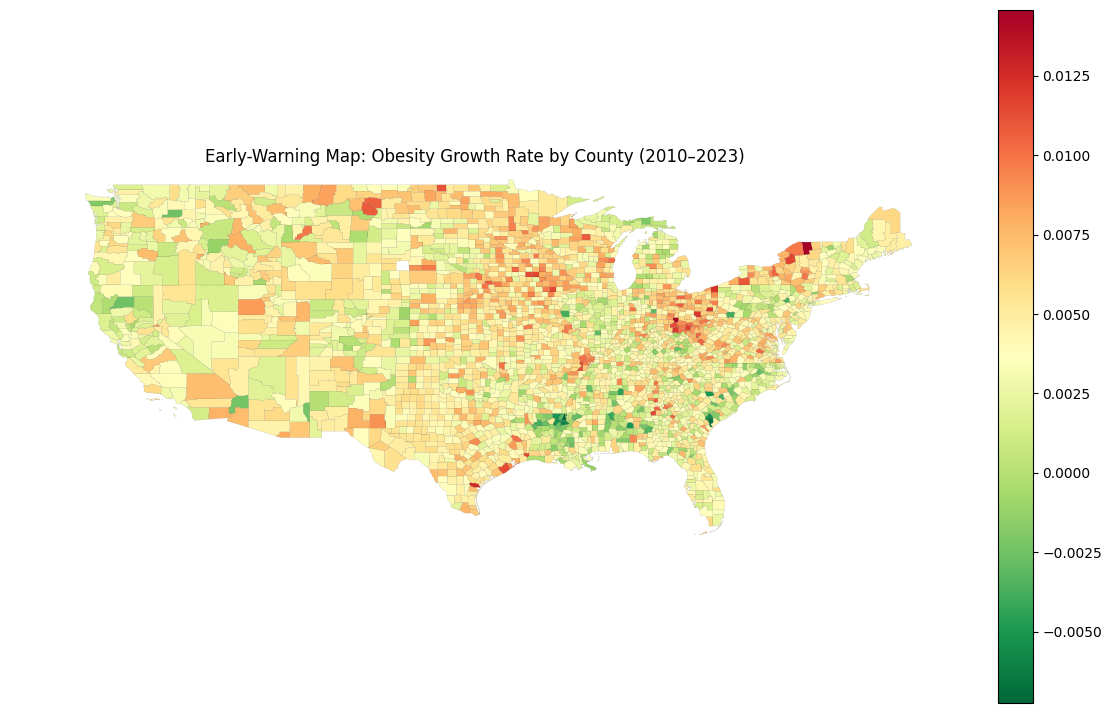

In [13]:

# This gdf does not contain the 'obesity_slope' column.
# The 'obesity_slope' column is computed in df_trend.
# We need to merge gdf_counties with df_trend to get the correct data for plotting.


# df_trend['fips'] currently holds the 'geoid' (e.g., 'us-al-001').
# df_time has both 'geoid' and 'fips' (5-digit).
# create a mapping from geoid to 5-digit fips from df_time.
geoid_to_fips_map = df_time[['geoid', 'fips']].drop_duplicates().set_index('geoid')['fips']

# Create a new 5-digit FIPS column in df_trend for merging
df_trend['five_digit_fips'] = df_trend['fips'].map(geoid_to_fips_map)

# Drop rows where mapping failed (if any geoid in df_trend was not in df_time)
df_trend_cleaned = df_trend.dropna(subset=['five_digit_fips'])

# Now merging gdf_counties with the cleaned df_trend
# gdf_counties has 'GEOID' (5-digit FIPS), and df_trend_cleaned has 'five_digit_fips'
gdf_for_plot = gdf_counties.merge(df_trend_cleaned, left_on="GEOID", right_on="five_digit_fips", how="inner")

fig, ax = plt.subplots(1, 1, figsize=(15, 9))

# Check if gdf_for_plot is empty before trying to plot
if not gdf_for_plot.empty:
    gdf_for_plot.plot(
        column="obesity_slope",
        cmap="RdYlGn_r",   # red = bad growth, green = stable/improving
        legend=True,
        edgecolor="black",
        linewidth=0.05,
        ax=ax
    )

    # Optional zoom to continental US
    ax.set_xlim([-130, -65])
    ax.set_ylim([24, 50])

    ax.set_title("Early-Warning Map: Obesity Growth Rate by County (2010–2023)")
    ax.axis("off")
    plt.show()
else:
    print("No data to plot: Merging gdf_counties and df_trend resulted in an empty GeoDataFrame.")

In [14]:
df_trend

,fips,obesity_slope,inactivity_slope,income_slope,poverty_slope,unemployment_slope,five_digit_fips
0,us-ak-013,0.004975,-0.001654,2823.703297,0.000194,-0.003521,02013
1,us-ak-110,0.003215,-0.000481,1914.564835,0.000185,-0.001465,02110
2,us-ak-122,0.003629,-0.001576,1260.101099,0.000446,-0.003078,02122
3,us-ak-130,0.007365,-0.000853,2098.149451,-0.001507,-0.002836,02130
4,us-ak-150,0.003049,0.001468,1806.824176,-0.000705,-0.001637,02150
...,...,...,...,...,...,...,...
3126,us-wy-037,0.005642,-0.001626,661.793407,0.000659,-0.000937,56037
3127,us-wy-039,0.002393,0.000446,4614.727473,-0.002747,-0.004008,56039
3128,us-wy-041,0.004278,-0.001062,1316.118681,-0.001342,-0.002120,56041
3129,us-wy-043,0.005580,-0.001121,1122.382418,-0.000812,-0.001621,56043


# Year-Over-Year changes and growth rates for Features

In [15]:
df_time

,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,geoid,year,county_name,state_abbr,metro_nonmetro,obesity_rate,poverty_rate,physical_inactivity,median_household_income,unemployment_rate,fips
0,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2010,Autauga County,AL,Metropolitan,0.287002,0.119001,0.248003,53049.0,0.088081,01001
1,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2011,Autauga County,AL,Metropolitan,0.260001,0.149001,0.261000,48863.0,0.083459,01001
2,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2012,Autauga County,AL,Metropolitan,0.295002,0.127000,0.242004,51441.0,0.071035,01001
3,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2013,Autauga County,AL,Metropolitan,0.284003,0.134999,0.259002,51868.0,0.063142,01001
4,"POLYGON ((-86.496774 32.344437, -86.717897 32....",0500000US01001,1,1,Autauga,County,594.436,1001,us-al-001,2014,Autauga County,AL,Metropolitan,0.311003,0.131001,0.248001,54366.0,0.058076,01001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43829,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2019,Chesterfield County,VA,Metropolitan,0.350001,0.066000,0.231000,81641.0,0.027124,51041
43830,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2020,Chesterfield County,VA,Metropolitan,0.356000,0.066000,0.219000,83598.0,0.060530,51041
43831,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2021,Chesterfield County,VA,Metropolitan,0.349000,0.074000,0.191000,86101.0,0.036161,51041
43832,"POLYGON ((-77.851804 37.354867, -77.855148 37....",0500000US51041,51,41,Chesterfield,County,423.297,51041,us-va-041,2022,Chesterfield County,VA,Metropolitan,0.363001,0.069000,0.196000,100149.0,0.027051,51041


In [21]:
# 1 Make sure panel is sorted correctly
df_time = df_time.sort_values(["geoid", "year"]).reset_index(drop=True)

# 2 Year-over-year changes and growth for obesity
df_time["obesity_yoy_change"] = df_time.groupby("geoid")["obesity_rate"].diff()
df_time["obesity_yoy_pct"]    = df_time.groupby("geoid")["obesity_rate"].pct_change()

# 3 Year-over-year changes for other drivers
df_time["inactivity_yoy_change"]   = df_time.groupby("geoid")["physical_inactivity"].diff()
df_time["poverty_yoy_change"]      = df_time.groupby("geoid")["poverty_rate"].diff()
df_time["income_yoy_pct"]          = df_time.groupby("geoid")["median_household_income"].pct_change()
df_time["unemployment_yoy_change"] = df_time.groupby("geoid")["unemployment_rate"].diff()

# 4 Acceleration of obesity change (2nd derivative)
df_time["obesity_yoy_acceleration"] = (
    df_time.groupby("geoid")["obesity_yoy_change"].diff()
)

df_time


,geometry,GEO_ID,STATE,COUNTY,NAME,LSAD,CENSUSAREA,GEOID,geoid,year,...,median_household_income,unemployment_rate,fips,obesity_yoy_change,obesity_yoy_pct,inactivity_yoy_change,poverty_yoy_change,income_yoy_pct,unemployment_yoy_change,obesity_yoy_acceleration
0,"MULTIPOLYGON (((-162.255031 54.978353, -162.24...",0500000US02013,2,13,Aleutians East,Borough,6981.943,2013,us-ak-013,2010,...,47077.0,0.058185,02013,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"MULTIPOLYGON (((-162.255031 54.978353, -162.24...",0500000US02013,2,13,Aleutians East,Borough,6981.943,2013,us-ak-013,2011,...,51289.0,0.063477,02013,0.004028,0.016920,-0.010044,0.010022,0.089470,0.005292,NaN
2,"MULTIPOLYGON (((-162.255031 54.978353, -162.24...",0500000US02013,2,13,Aleutians East,Borough,6981.943,2013,us-ak-013,2012,...,51514.0,0.069014,02013,0.024009,0.099183,0.012986,-0.021005,0.004387,0.005537,0.019981
3,"MULTIPOLYGON (((-162.255031 54.978353, -162.24...",0500000US02013,2,13,Aleutians East,Borough,6981.943,2013,us-ak-013,2013,...,56856.0,0.060716,02013,-0.015005,-0.056396,0.037075,-0.005007,0.103700,-0.008298,-0.039014
4,"MULTIPOLYGON (((-162.255031 54.978353, -162.24...",0500000US02013,2,13,Aleutians East,Borough,6981.943,2013,us-ak-013,2014,...,55462.0,0.044164,02013,0.016006,0.063752,-0.026002,0.009996,-0.024518,-0.016552,0.031011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43829,"POLYGON ((-104.055077 43.936535, -104.055104 4...",0500000US56045,56,45,Weston,County,2398.089,56045,us-wy-045,2019,...,59410.0,0.030087,56045,0.018019,0.054768,0.013005,-0.013006,0.093724,-0.005325,0.018019
43830,"POLYGON ((-104.055077 43.936535, -104.055104 4...",0500000US56045,56,45,Weston,County,2398.089,56045,us-wy-045,2020,...,58901.0,0.038563,56045,-0.023012,-0.066312,-0.007016,0.001003,-0.008568,0.008476,-0.041032
43831,"POLYGON ((-104.055077 43.936535, -104.055104 4...",0500000US56045,56,45,Weston,County,2398.089,56045,us-wy-045,2021,...,62509.0,0.032310,56045,0.009996,0.030850,0.020026,-0.001997,0.061255,-0.006253,0.033009
43832,"POLYGON ((-104.055077 43.936535, -104.055104 4...",0500000US56045,56,45,Weston,County,2398.089,56045,us-wy-045,2022,...,67677.0,0.025634,56045,-0.025991,-0.077813,-0.045003,0.010993,0.082676,-0.006676,-0.035987


In [22]:
# Focus on recent years (you can change 2019 cut if you want) - Key metrics
recent = df_time[df_time["year"] >= 2019].copy()

recent_agg = (
    recent.groupby("geoid")
    .agg(
        recent_obesity_yoy_mean   = ("obesity_yoy_change", "mean"),
        recent_obesity_accel_mean = ("obesity_yoy_acceleration", "mean"),
        recent_obesity_volatility = ("obesity_yoy_change", "std"),
        recent_inactivity_yoy_mean   = ("inactivity_yoy_change", "mean"),
        recent_poverty_yoy_mean      = ("poverty_yoy_change", "mean"),
        recent_income_yoy_pct_mean   = ("income_yoy_pct", "mean"),
    )
    .reset_index()
)

# Map to 5-digit FIPS for easy spatial join later
recent_agg["five_digit_fips"] = recent_agg["geoid"].map(geoid_to_fips_map)

recent_agg.head()


,geoid,recent_obesity_yoy_mean,recent_obesity_accel_mean,recent_obesity_volatility,recent_inactivity_yoy_mean,recent_poverty_yoy_mean,recent_income_yoy_pct_mean,five_digit_fips
0,us-ak-013,-0.004793,2.015597e-04,0.018356,-0.007196,0.005001,0.041690,02013
1,us-ak-110,0.009800,-6.838158e-07,0.022410,-0.004400,0.003600,0.048728,02110
2,us-ak-122,-0.004400,-5.800459e-03,0.028840,-0.002200,-0.001800,0.026041,02122
3,us-ak-130,0.000601,-3.604071e-03,0.014764,0.000998,0.000400,0.053326,02130
4,us-ak-150,0.004601,3.198360e-03,0.019742,-0.003402,0.000600,0.033467,02150


In [23]:
def compute_slope(years, values):
    years = years.values.reshape(-1, 1)
    return LinearRegression().fit(years, values).coef_[0]

pre_post_rows = []

for geoid, g in df_time.groupby("geoid"):
    g = g.sort_values("year")

    # Pre-COVID: up to 2019
    g_pre = g[g["year"] <= 2019]
    pre_slope = compute_slope(g_pre["year"], g_pre["obesity_rate"]) if len(g_pre) >= 5 else np.nan

    # Post-COVID: 2020 onwards
    g_post = g[g["year"] >= 2020]
    post_slope = compute_slope(g_post["year"], g_post["obesity_rate"]) if len(g_post) >= 3 else np.nan

    pre_post_rows.append({
        "fips": geoid,  # match df_trend['fips']
        "obesity_slope_pre2019": pre_slope,
        "obesity_slope_post2020": post_slope,
    })

df_pre_post = pd.DataFrame(pre_post_rows)

# Merge into df_trend
df_trend = df_trend.merge(df_pre_post, on="fips", how="left")

df_trend.head()


,fips,obesity_slope,inactivity_slope,income_slope,poverty_slope,unemployment_slope,five_digit_fips,obesity_slope_pre2019,obesity_slope_post2020
0,us-ak-013,0.004975,-0.001654,2823.703297,0.000194,-0.003521,02013,0.009210,-0.011982
1,us-ak-110,0.003215,-0.000481,1914.564835,0.000185,-0.001465,02110,0.001333,0.019703
2,us-ak-122,0.003629,-0.001576,1260.101099,0.000446,-0.003078,02122,0.004491,0.001800
3,us-ak-130,0.007365,-0.000853,2098.149451,-0.001507,-0.002836,02130,0.010273,0.008000
4,us-ak-150,0.003049,0.001468,1806.824176,-0.000705,-0.001637,02150,0.003588,-0.001898


In [25]:
# Use recent panel (e.g. 2020+)
recent_panel = df_time[df_time["year"] >= 2020].copy()

def classify_driver(row):
    if pd.isna(row["obesity_yoy_change"]):
        return np.nan

    # If obesity not rising, we treat as "Improving"
    if row["obesity_yoy_change"] <= 0:
        return "Improving"

    # Obesity is rising:
    if row["inactivity_yoy_change"] > 0:
        return "Behavioral"
    if row["poverty_yoy_change"] > 0:
        return "Economic"
    if row["income_yoy_pct"] > 0:
        return "Structural"
    return "Other"

recent_panel["driver_type"] = recent_panel.apply(classify_driver, axis=1)

# Silent policy failure:
#   poverty ↓, income ↑, but obesity ↑
recent_panel["policy_failure"] = (
    (recent_panel["obesity_yoy_change"] > 0) &
    (recent_panel["poverty_yoy_change"] < 0) &
    (recent_panel["income_yoy_pct"] > 0)
)

# Take the *latest* year per county as current classification
driver_summary = (
    recent_panel.sort_values(["geoid", "year"])
    .groupby("geoid")
    .tail(1)[["geoid", "driver_type", "policy_failure"]]
)

# Merge with df_trend
df_trend = df_trend.merge(driver_summary, left_on="fips", right_on="geoid", how="left")

df_trend["policy_failure"].value_counts(dropna=False)


,count
policy_failure,
False,2455
True,676


In [26]:
latest = (
    df_time.sort_values(["geoid", "year"])
    .groupby("geoid")
    .tail(1)[[
        "geoid",
        "year",
        "obesity_rate",
        "physical_inactivity",
        "poverty_rate",
        "median_household_income",
        "unemployment_rate"
    ]]
    .rename(columns={
        "obesity_rate": "obesity_latest",
        "physical_inactivity": "inactivity_latest",
        "poverty_rate": "poverty_latest",
        "median_household_income": "income_latest",
        "unemployment_rate": "unemployment_latest"
    })
)

df_trend = df_trend.merge(latest, left_on="fips", right_on="geoid", how="left")

df_trend.head()


,fips,obesity_slope,inactivity_slope,income_slope,poverty_slope,unemployment_slope,five_digit_fips,obesity_slope_pre2019,obesity_slope_post2020,geoid_x,driver_type,policy_failure,geoid_y,year,obesity_latest,inactivity_latest,poverty_latest,income_latest,unemployment_latest
0,us-ak-013,0.004975,-0.001654,2823.703297,0.000194,-0.003521,02013,0.009210,-0.011982,us-ak-013,Improving,False,us-ak-013,2023,0.272066,0.183035,0.180035,83000.0,0.021015
1,us-ak-110,0.003215,-0.000481,1914.564835,0.000185,-0.001465,02110,0.001333,0.019703,us-ak-110,Improving,False,us-ak-110,2023,0.307010,0.145005,0.091000,99748.0,0.029935
2,us-ak-122,0.003629,-0.001576,1260.101099,0.000446,-0.003078,02122,0.004491,0.001800,us-ak-122,Improving,False,us-ak-122,2023,0.301002,0.197001,0.115001,74185.0,0.047178
3,us-ak-130,0.007365,-0.000853,2098.149451,-0.001507,-0.002836,02130,0.010273,0.008000,us-ak-130,Economic,False,us-ak-130,2023,0.375009,0.209000,0.093001,87760.0,0.036757
4,us-ak-150,0.003049,0.001468,1806.824176,-0.000705,-0.001637,02150,0.003588,-0.001898,us-ak-150,Improving,False,us-ak-150,2023,0.301020,0.203004,0.085003,86250.0,0.044118


# Early Warning Risk Score

In [27]:
# Join recent-agg features into df_trend (using geoid / fips)
df_trend = df_trend.merge(
    recent_agg[["geoid",
                "recent_obesity_yoy_mean",
                "recent_obesity_accel_mean",
                "recent_obesity_volatility",
                "recent_inactivity_yoy_mean",
                "recent_poverty_yoy_mean",
                "recent_income_yoy_pct_mean"]],
    left_on="fips",
    right_on="geoid",
    how="left"
)

# Components for scaling (drop rows with any missing in these columns)
risk_source_cols = [
    "obesity_latest",
    "obesity_slope",
    "recent_obesity_yoy_mean",
    "recent_obesity_accel_mean",
    "inactivity_latest",
]

risk_df = df_trend[risk_source_cols].copy()
mask_valid = ~risk_df.isna().any(axis=1)

scaler = MinMaxScaler()
risk_scaled = pd.DataFrame(
    scaler.fit_transform(risk_df[mask_valid]),
    columns=[c + "_scaled" for c in risk_source_cols],
    index=df_trend[mask_valid].index
)

# Attach scaled columns
for col in risk_scaled.columns:
    df_trend[col] = risk_scaled[col]

# Composite risk score (weights are your choice; these are reasonable)
df_trend["risk_score"] = np.nan
valid_idx = mask_valid[mask_valid].index  # only rows we scaled

df_trend.loc[valid_idx, "risk_score"] = (
    0.35 * df_trend.loc[valid_idx, "obesity_latest_scaled"] +
    0.25 * df_trend.loc[valid_idx, "obesity_slope_scaled"] +
    0.25 * df_trend.loc[valid_idx, "recent_obesity_yoy_mean_scaled"] +
    0.15 * df_trend.loc[valid_idx, "recent_obesity_accel_mean_scaled"]
)

# Rank: 1 = highest risk
df_trend["intervention_rank"] = df_trend["risk_score"].rank(ascending=False)

df_trend[["fips", "five_digit_fips", "risk_score", "intervention_rank"]].head()


,fips,five_digit_fips,risk_score,intervention_rank
0,us-ak-013,02013,0.446881,2493.0
1,us-ak-110,02110,0.558210,1161.0
2,us-ak-122,02122,0.449478,2469.0
3,us-ak-130,02130,0.616876,545.0
4,us-ak-150,02150,0.526550,1593.0


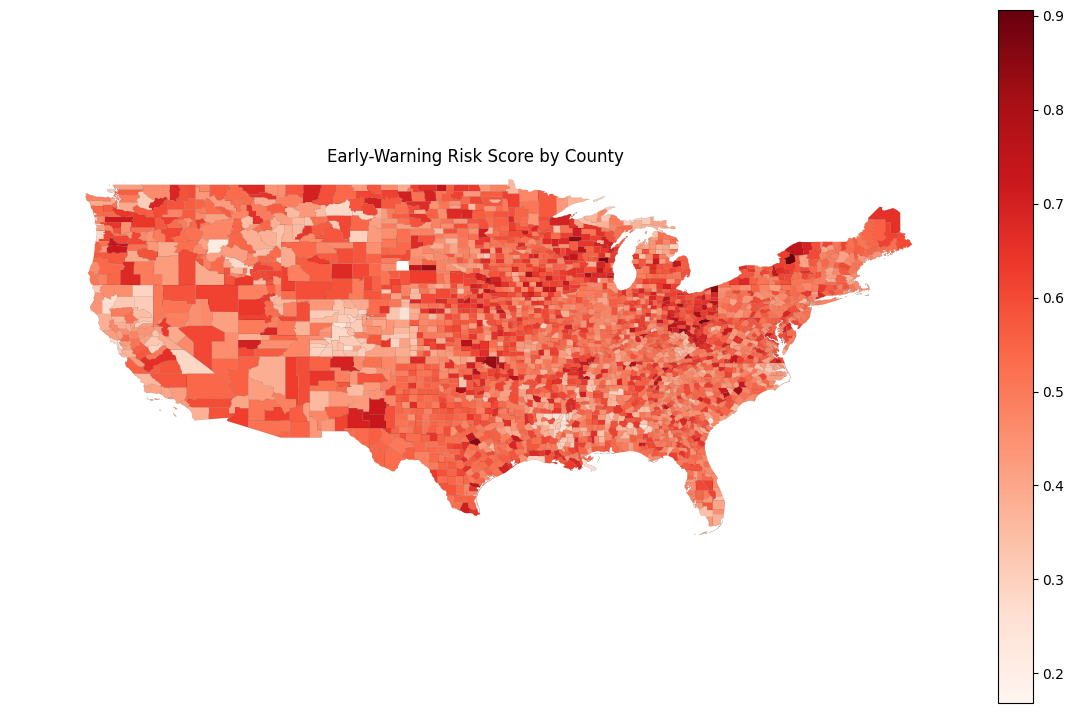

In [28]:
# Making sure we still have a clean FIPS column
df_trend["five_digit_fips"] = df_trend["five_digit_fips"].fillna(
    df_trend["fips"].map(geoid_to_fips_map)
)

df_trend_cleaned = df_trend.dropna(subset=["five_digit_fips"])

gdf_risk = gdf_counties.merge(
    df_trend_cleaned,
    left_on="GEOID",
    right_on="five_digit_fips",
    how="inner"
)

fig, ax = plt.subplots(1, 1, figsize=(15, 9))

if not gdf_risk.empty:
    gdf_risk.plot(
        column="risk_score",
        cmap="Reds",  # dark red = highest risk
        legend=True,
        edgecolor="black",
        linewidth=0.05,
        ax=ax
    )
    ax.set_xlim([-130, -65])
    ax.set_ylim([24, 50])
    ax.set_title("Early-Warning Risk Score by County")
    ax.axis("off")
    plt.show()
else:
    print("No data to plot for risk_score.")


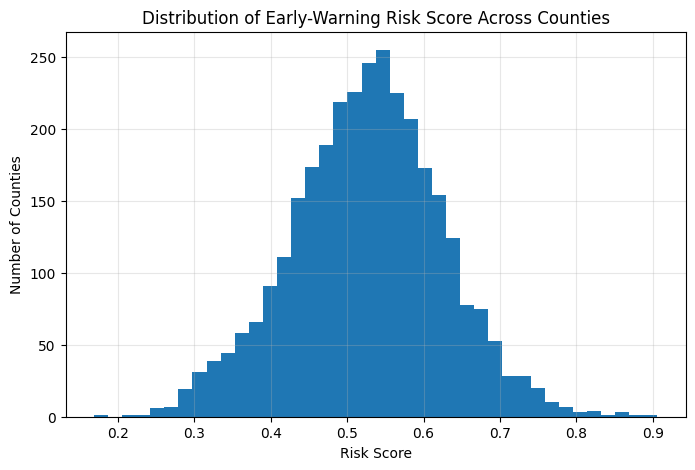

In [29]:
plt.figure(figsize=(8,5))
plt.hist(df_trend["risk_score"].dropna(), bins=40)
plt.title("Distribution of Early-Warning Risk Score Across Counties")
plt.xlabel("Risk Score")
plt.ylabel("Number of Counties")
plt.grid(True, alpha=0.3)
plt.show()


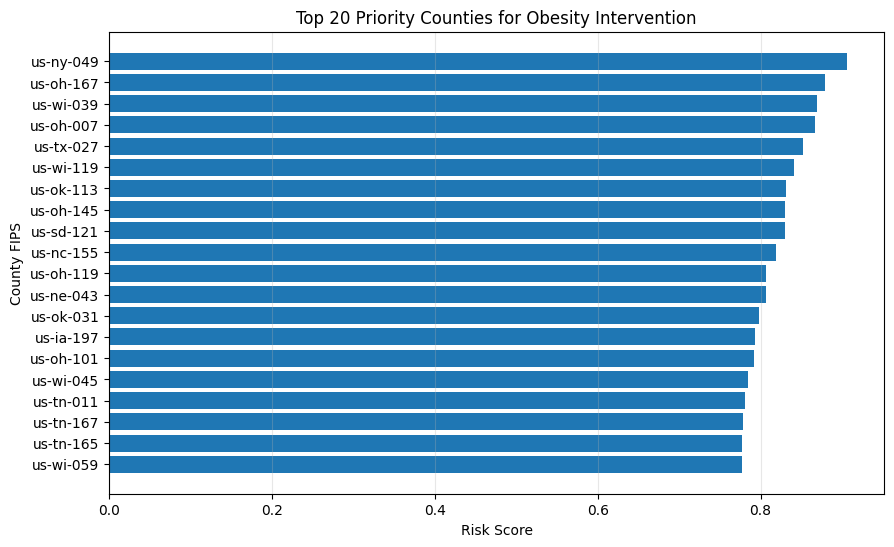

In [30]:
top20 = df_trend.sort_values("intervention_rank").head(20)

plt.figure(figsize=(10,6))
plt.barh(top20["fips"].astype(str), top20["risk_score"])
plt.gca().invert_yaxis()
plt.title("Top 20 Priority Counties for Obesity Intervention")
plt.xlabel("Risk Score")
plt.ylabel("County FIPS")
plt.grid(True, axis="x", alpha=0.3)
plt.show()


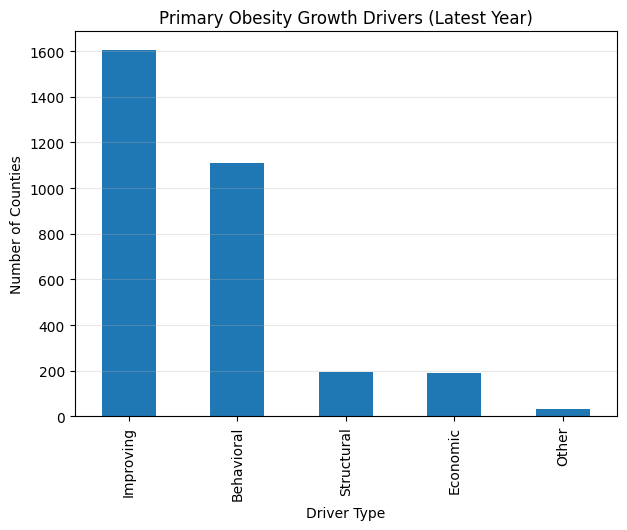

In [31]:
driver_counts = df_trend["driver_type"].value_counts()

plt.figure(figsize=(7,5))
driver_counts.plot(kind="bar")
plt.title("Primary Obesity Growth Drivers (Latest Year)")
plt.xlabel("Driver Type")
plt.ylabel("Number of Counties")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


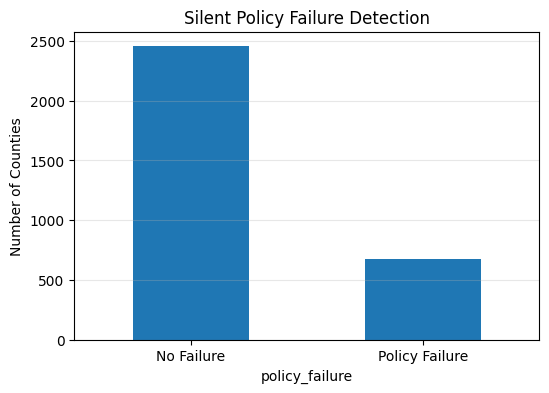

In [32]:
pf = df_trend["policy_failure"].value_counts()

plt.figure(figsize=(6,4))
pf.plot(kind="bar")
plt.title("Silent Policy Failure Detection")
plt.xticks([0,1], ["No Failure", "Policy Failure"], rotation=0)
plt.ylabel("Number of Counties")
plt.grid(True, axis="y", alpha=0.3)
plt.show()


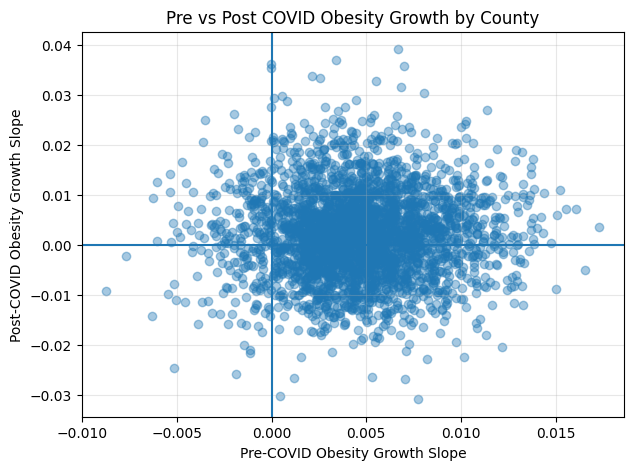

In [33]:
plt.figure(figsize=(7,5))
plt.scatter(
    df_trend["obesity_slope_pre2019"],
    df_trend["obesity_slope_post2020"],
    alpha=0.4
)
plt.axhline(0)
plt.axvline(0)
plt.xlabel("Pre-COVID Obesity Growth Slope")
plt.ylabel("Post-COVID Obesity Growth Slope")
plt.title("Pre vs Post COVID Obesity Growth by County")
plt.grid(True, alpha=0.3)
plt.show()


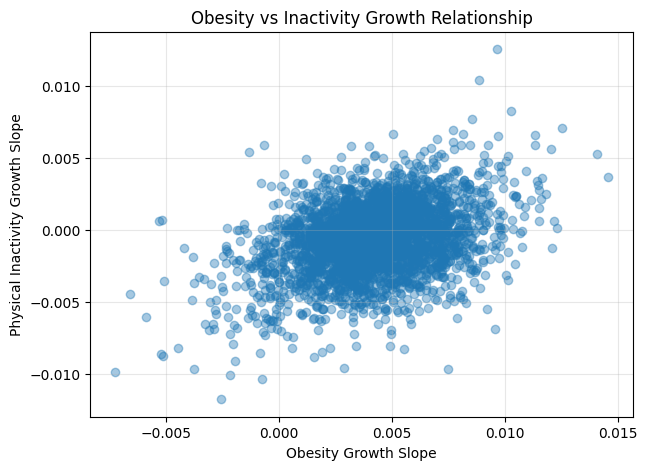

In [34]:
plt.figure(figsize=(7,5))
plt.scatter(
    df_trend["obesity_slope"],
    df_trend["inactivity_slope"],
    alpha=0.4
)
plt.xlabel("Obesity Growth Slope")
plt.ylabel("Physical Inactivity Growth Slope")
plt.title("Obesity vs Inactivity Growth Relationship")
plt.grid(True, alpha=0.3)
plt.show()


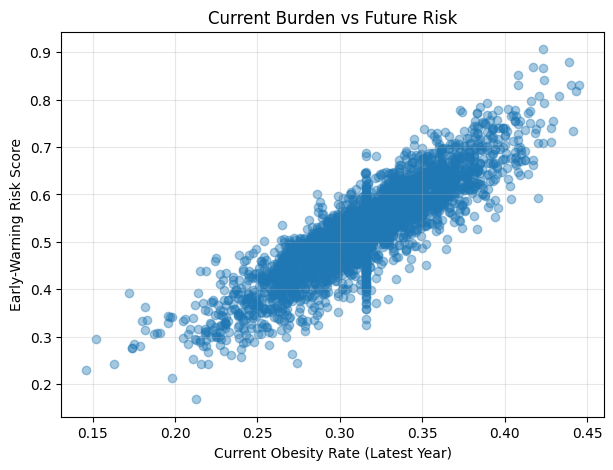

In [35]:
plt.figure(figsize=(7,5))
plt.scatter(
    df_trend["obesity_latest"],
    df_trend["risk_score"],
    alpha=0.4
)
plt.xlabel("Current Obesity Rate (Latest Year)")
plt.ylabel("Early-Warning Risk Score")
plt.title("Current Burden vs Future Risk")
plt.grid(True, alpha=0.3)
plt.show()


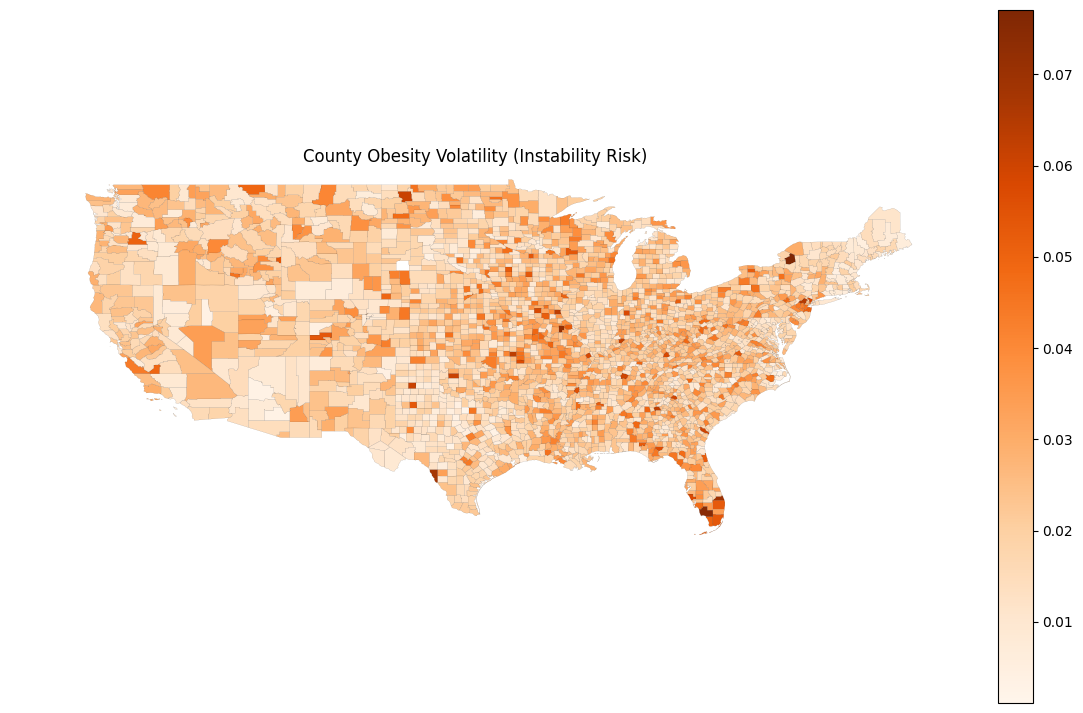

In [36]:
gdf_vol = gdf_counties.merge(
    df_trend.dropna(subset=["five_digit_fips"]),
    left_on="GEOID",
    right_on="five_digit_fips",
    how="inner"
)

fig, ax = plt.subplots(1,1, figsize=(15,9))
gdf_vol.plot(
    column="recent_obesity_volatility",
    cmap="Oranges",
    legend=True,
    edgecolor="black",
    linewidth=0.05,
    ax=ax
)
ax.set_xlim([-130, -65])
ax.set_ylim([24, 50])
ax.set_title("County Obesity Volatility (Instability Risk)")
ax.axis("off")
plt.show()
